# Deteksi Buah dan Sayuran V1

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

from tensorflow.keras.applications.inception_v3 import InceptionV3,preprocess_input
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow.keras.backend as K

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.8.0
Hub version: 0.12.0
GPU is NOT AVAILABLE


# Prepartion Data

In [3]:
base_dir = "Vegetable-Images"

print("Contents of base directory:")
print(os.listdir(base_dir))

print("\nContents of train directory:")
print(os.listdir(f'{base_dir}/train'))

print("\nContents of validation directory:")
print(os.listdir(f'{base_dir}/validation'))

Contents of base directory:
['test', 'train', 'validation']

Contents of train directory:
['Bean', 'Bitter_Gourd', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Tomato']

Contents of validation directory:
['Bean', 'Bitter_Gourd', 'Broccoli', 'Cabbage', 'Capsicum', 'Carrot', 'Cauliflower', 'Cucumber', 'Papaya', 'Potato', 'Pumpkin', 'Tomato']


In [4]:
mainFolder ='Vegetable-Images'

trainFolder = os.path.join(mainFolder,"train")
testFolder = os.path.join(mainFolder,"validation")
valFolder = os.path.join(mainFolder,"test")


os.chmod(trainFolder, 755)

# Visualize Data

In [23]:
file_names = []
classes = []

for folder in os.listdir(trainFolder):
    new_path = os.path.join(trainFolder,folder)
    for file in os.listdir(new_path):
        file_names.append(os.path.join(new_path,file))
        classes.append(folder)

data = pd.DataFrame({'filenames':file_names,'class':classes})
data['class'].value_counts()

Papaya          1000
Bean            1000
Carrot          1000
Capsicum        1000
Potato          1000
Broccoli        1000
Tomato          1000
Cucumber        1000
Cauliflower     1000
Pumpkin         1000
Cabbage         1000
Bitter_Gourd    1000
Name: class, dtype: int64

<AxesSubplot:xlabel='class', ylabel='count'>

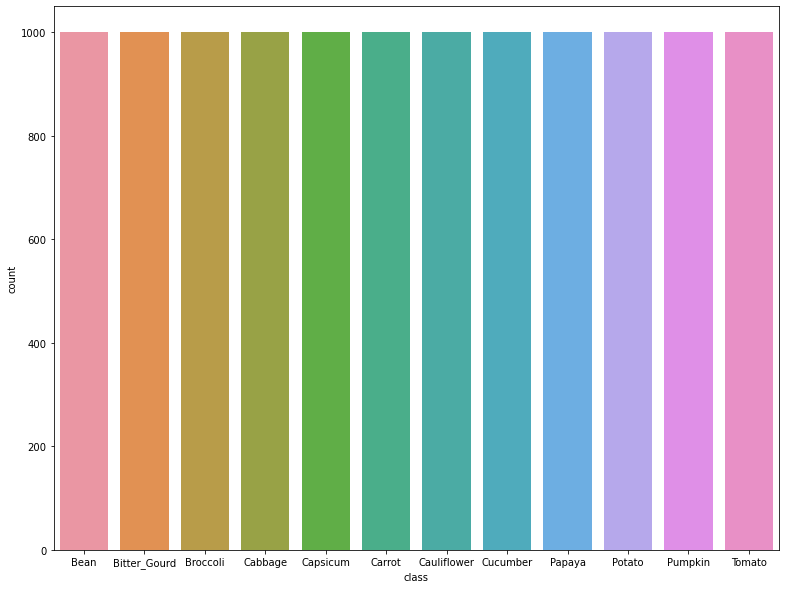

In [27]:
%matplotlib inline 
fig = plt.figure(figsize=(13,10))
sns.countplot(x='class', data=data)

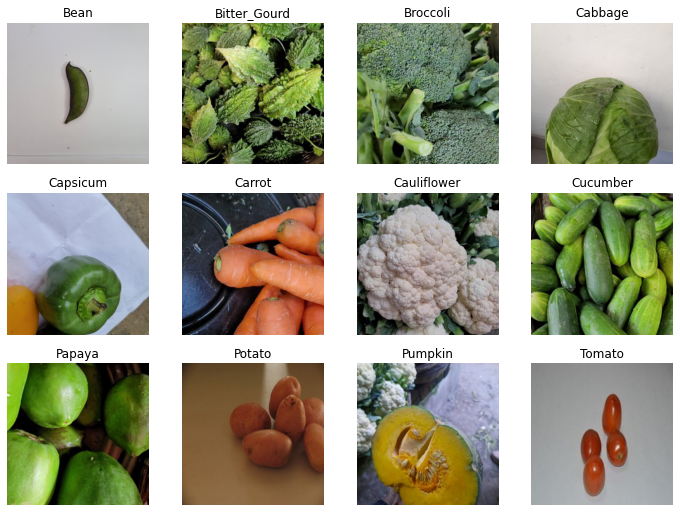

In [7]:
def plot_images(image_categories):
    
    # Create a figure
    plt.figure(figsize=(12, 12))
    for i, cat in enumerate(image_categories):
        
        # Load images for the ith category
        image_path = trainFolder + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255.0
        
        
        # Create Subplot and plot the images
        plt.subplot(4, 4, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')
        
    plt.show()

# Call the function
plot_images(os.listdir(trainFolder))

# Preparation Model

In [6]:
# Apply data augmentation
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,)

validation_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        trainFolder,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        testFolder,  # This is the source directory for training images
        target_size=(224, 224),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

Found 12000 images belonging to 12 classes.
Found 2400 images belonging to 12 classes.


(32, 224, 224, 3)


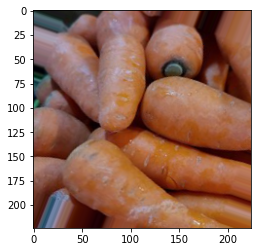

In [7]:
for _ in range(1):
    img, label = train_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

In [8]:
class_map = train_generator.class_indices
class_map

{'Bean': 0,
 'Bitter_Gourd': 1,
 'Broccoli': 2,
 'Cabbage': 3,
 'Capsicum': 4,
 'Carrot': 5,
 'Cauliflower': 6,
 'Cucumber': 7,
 'Papaya': 8,
 'Potato': 9,
 'Pumpkin': 10,
 'Tomato': 11}

# Build Model

In [9]:
# Import Library
import tensorflow as tf

In [12]:
IMAGE_SIZE = [224, 224]

inception = tf.keras.applications.Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(12, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [13]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [14]:
r = model.fit_generator(
  train_generator,
  validation_data=validation_generator,
  epochs=5,
  steps_per_epoch=len(train_generator),
  validation_steps=len(validation_generator)
)

<ipython-input-14-18817aeb3e10>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/5
375/375 [==============================] - 1068s 3s/step - loss: 0.1233 - accuracy: 0.9664 - val_loss: 0.0371 - val_accuracy: 0.9875
Epoch 2/5
375/375 [==============================] - 1109s 3s/step - loss: 0.0320 - accuracy: 0.9908 - val_loss: 0.0191 - val_accuracy: 0.9937
Epoch 3/5
375/375 [==============================] - 971s 3s/step - loss: 0.0296 - accuracy: 0.9908 - val_loss: 0.0139 - val_accuracy: 0.9946
Epoch 4/5
375/375 [==============================] - 971s 3s/step - loss: 0.0164 - accuracy: 0.9945 - val_loss: 0.0217 - val_accuracy: 0.9937
Epoch 5/5
375/375 [==============================] - 974s 3s/step - loss: 0.0175 - accuracy: 0.9944 - val_loss: 0.0128 - val_accuracy: 0.9954


In [15]:
model.save('model_Xception_13Classes.h5')

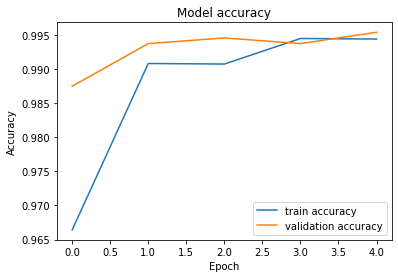

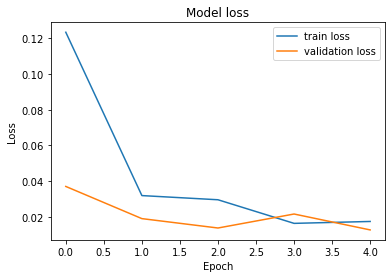

In [16]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

plot_accuracy(r)
plot_loss(r)

In [11]:
K.clear_session()
path_to_model='./model_Xception_13Classes.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


# Evaluation

In [12]:
validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    valFolder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 2400 images belonging to 12 classes.


<ipython-input-12-f3e0df37f7db>:9: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(validation_generator)


Test Accuracy: 0.997


In [31]:
category={
    0: 'Bean', 
    1: 'Bitter_Gourd', 
    2: "Broccoli", 
    3: 'Cabbage', 
    4: 'Capsicum', 
    5: 'Carrot', 
    6: 'Cauliflower',
    7: 'Cucumber', 
    8: 'Papaya', 
    9: 'Potato', 
    10: 'Pumpkin', 
    11: "Tomato"
}

def predict_image(filename,model):
    counter = 0
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    for values in prediction:
        for value in values:
            if value > 0.85:
                counter = 1

    if counter == 1:
        index = np.argmax(prediction)
        accuracy = prediction[0][index]
    else:
        print('tidak terdeteksi')
        return None

    index = np.argmax(prediction)
    
    plt.title("Prediction - {}, Accuracy - {}".format(category[index],accuracy))
    plt.imshow(img_array)

In [32]:
predict_image('mobil.jpg',model)

tidak terdeteksi


# Build Mode Fix

In [9]:


IMAGE_SIZE = [224, 224]

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in inception.layers:
    layer.trainable = False

x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

prediction = Dense(15, activation='softmax')(x)

model = Model(inputs=inception.input, outputs=prediction)

model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [67]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_5 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_5 (TFOpLam  (None, 224, 224, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                    

In [10]:
r = model.fit_generator(
  train_generator,
  validation_data=validation_generator,
  epochs=5,
  steps_per_epoch=len(train_generator),
  validation_steps=len(validation_generator)
)

<ipython-input-10-18817aeb3e10>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(


Epoch 1/5
469/469 [==============================] - 558s 1s/step - loss: 0.2592 - accuracy: 0.9188 - val_loss: 0.0536 - val_accuracy: 0.9820
Epoch 2/5
469/469 [==============================] - 558s 1s/step - loss: 0.0870 - accuracy: 0.9735 - val_loss: 0.0396 - val_accuracy: 0.9903
Epoch 3/5
469/469 [==============================] - 551s 1s/step - loss: 0.0651 - accuracy: 0.9788 - val_loss: 0.0357 - val_accuracy: 0.9893
Epoch 4/5
469/469 [==============================] - 557s 1s/step - loss: 0.0606 - accuracy: 0.9815 - val_loss: 0.0343 - val_accuracy: 0.9893
Epoch 5/5
469/469 [==============================] - 545s 1s/step - loss: 0.0565 - accuracy: 0.9830 - val_loss: 0.0323 - val_accuracy: 0.9887


In [11]:
model.save('model_inceptionV3_epoch5.h5')

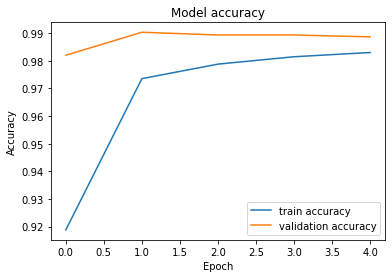

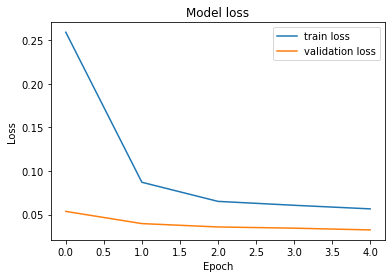

In [13]:
def plot_accuracy(history):
    
    plt.plot(history.history['accuracy'],label='train accuracy')
    plt.plot(history.history['val_accuracy'],label='validation accuracy')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()
    
def plot_loss(history):
    
    plt.plot(history.history['loss'],label="train loss")
    plt.plot(history.history['val_loss'],label="validation loss")
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    plt.show()

plot_accuracy(r)
plot_loss(r)

In [3]:
K.clear_session()
path_to_model='./model_inceptionV3_epoch5.h5'
print("Loading the model..")
model = load_model(path_to_model)
print("Done!")

Loading the model..
Done!


In [6]:


validation_datagen = image.ImageDataGenerator(rescale=1. / 255)

validation_generator = validation_datagen.flow_from_directory(
    valFolder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical')

scores = model.evaluate_generator(validation_generator)
print("Test Accuracy: {:.3f}".format(scores[1]))

Found 3000 images belonging to 15 classes.


<ipython-input-6-f3e0df37f7db>:9: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(validation_generator)


Test Accuracy: 0.988


In [7]:
category={
    0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3 : 'Brinjal', 4: "Broccoli", 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower',
    9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13 : "Radish", 14: "Tomato"
}

def predict_image(filename,model):
    img_ = image.load_img(filename, target_size=(224, 224))
    img_array = image.img_to_array(img_)
    img_processed = np.expand_dims(img_array, axis=0) 
    img_processed /= 255.   
    
    prediction = model.predict(img_processed)
    index = np.argmax(prediction)
    
    plt.title("Prediction - {}".format(category[index]))
    plt.imshow(img_array)
    
def predict_dir(filedir,model):
    cols=3
    pos=0
    images=[]
    total_images=len(os.listdir(filedir))
    rows=total_images//cols + 1
    
    true=filedir.split('/')[-1]
    
    for i in sorted(os.listdir(filedir)):
        images.append(os.path.join(filedir,i))
        
    for subplot, imggg in enumerate(images):
        img_ = image.load_img(imggg, target_size=(224, 224))
        img_array = image.img_to_array(img_)
        img_processed = np.expand_dims(img_array, axis=0) 
        img_processed /= 255.
        prediction = model.predict(img_processed)
        index = np.argmax(prediction)
        
        pred=category.get(index)
        if pred==true:
            pos+=1

    acc=pos/total_images
    print("Accuracy for {orignal}: {:.2f} ({pos}/{total})".format(acc,pos=pos,total=total_images,orignal=true))

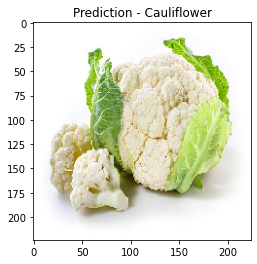

In [8]:
predict_image('kol.jpg',model)

# Build Model V2

In [12]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
import tensorflow as tf

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [7]:
# Import the inception model  


# Create an instance of the inception model from the local pre-trained weights
local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [8]:
# GRADED FUNCTION: create_pre_trained_model
def create_pre_trained_model(local_weights_file):
  ### START CODE HERE
  pre_trained_model = InceptionV3(input_shape = (224, 224, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for layer in pre_trained_model.layers:
    layer.trainable = False

  ### END CODE HERE

  return pre_trained_model
  

In [9]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [10]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


In [13]:
# Define a Callback class that stops training once accuracy reaches 99.9%

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [14]:
# GRADED FUNCTION: output_of_last_layer
def output_of_last_layer(pre_trained_model):
  ### START CODE HERE
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  ### END CODE HERE

  return last_output


In [15]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 12, 12, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 12, 12, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


In [16]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


In [23]:
# GRADED FUNCTION: create_final_model
def create_final_model(pre_trained_model, last_output):
  # Flatten the output layer to 1 dimension
  x = tf.keras.layers.Flatten()(last_output)

  ### START CODE HERE

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = tf.keras.layers.Dense(512,activation='relu')(x)
  # Add a dropout rate of 0.2
  x = tf.keras.layers.Dropout(0.2)(x)
  # Add a final sigmoid layer for classification
  x = tf.keras.layers.Dense(15,activation='softmax')(x)       

  # Create the complete model by using the Model class
  model = tf.keras.Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
                loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

  ### END CODE HERE
  
  return model


In [24]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 65,606,575 total parameters in this model.
There are 56,631,311 trainable parameters in this model.


In [25]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take a few epochs)
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 10,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/10


KeyboardInterrupt: 